In [1]:
import numpy as np

In [2]:
class Atom:
    def __init__(self,x,y,z,element,charge,notused,fx,fy,fz):
        self.x=float(x)
        self.y=float(y)
        self.z=float(z)
        self.element=str(element)
        self.charge=float(charge)
        self.notused=int(float(notused))
        self.fx=float(fx)
        self.fy=float(fy)
        self.fz=float(fz)
    
    @classmethod
    def from_lammps(cls, element, x, y, z,notused):
        obj = object.__new__(cls)
        obj.x = float(x)
        obj.y = float(y)
        obj.z = float(z)
        obj.element = str(element)
        obj.notused = notused
        return obj
    
    def scan_vicinity(self,config,cutoff,boxl):
        pivot=np.array([self.x,self.y,self.z])
        config=np.array(config)
        for ind,i in enumerate(config):
            #print(str(ind)+" element= "+i.element,type(i.notused))
            if(i.notused!=0):
                pass
            elif(i.element=="O"):
                i_vector=np.array([i.x,i.y,i.z])
                #print("O at"+str(ind))
                direction=pivot-i_vector
                direction[0]=direction[0]-(boxl*np.round(direction[0]/boxl))
                direction[1]=direction[1]-(boxl*np.round(direction[1]/boxl))
                direction[2]=direction[2]-(boxl*np.round(direction[2]/boxl))
                dist=np.linalg.norm(direction)
                if(dist<cutoff):
                    #can set notused = 1 here. Need to ponder
                    
                    return False
        return True
                

In [3]:
def parse(f_name):
    config=[]
    with open(f_name,'r') as f:
        temp=[]
        for i in f.readlines():
            i=str(i)
            #print(i)
            if("begin" in i):
                temp=[]
            elif("end" in i):
                config.append(temp)
                break # need to remove for a whole file
            elif(i.startswith("atom")):
                a=i.split()
                temp.append(Atom(a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8],a[9]))
    #for j in config:
    #    for i in j:
    #        print(i.element,type(i.element))
    return config                  

In [4]:
def parse_lammps_output(f_name):
    atoms=['O','H']
    config=[]
    with open(f_name,'r') as f:
        temp=[]
        for ind,i in enumerate(f.readlines()):
            i=str(i)
            if("ITEM: TIMESTEP" in i):
                if(ind>0):
                    config.append(temp)
                temp=[]
            elif(any(i.startswith(a) for a in atoms)):
                a=i.split()
                #print(a)
                temp.append(Atom.from_lammps(a[0],a[1],a[2],a[3],0))
    return config


In [24]:
def pH(proton_count,boxl,Na):
    print("Proton Count = "+str(proton_count))
    n=proton_count/Na
    vol=boxl**3
    #Molarity=n/vol
    #print("molarity=",Molarity)
    return -1*(np.log10(n)-np.log10(vol))

In [25]:
from sys import argv as a
import numpy as np
import matplotlib.pyplot as plt

def main():
    cutoff=1.15 # 2.173185 # needs to be atomic units since the coordinates are in atomic units
    boxl_atomic=46.937#23.465110
    Na=6.0221409e+23
    atomic_to_angstron=0.5291772083
    boxl_angstron=boxl_atomic*atomic_to_angstron
    boxl_meters=boxl_angstron**-8
    
    
    #config=parse("../training-set/input.data")
    config=parse_lammps_output("./out6.lammpstrj")
    #print(config[0])
    
    
    config=config[:100]
    print("config size",np.shape(config))
    protons=[]
    
    
    for ind,j in enumerate(config):
        proton_count=0
        for ind2,i in enumerate(j):
            if(i.element=="H"):
                #print("H at"+str(ind2))
                if(i.scan_vicinity(j,cutoff,boxl)):
                    proton_count=proton_count+1
                    #print("atom number %d is a proton and the element is %s"%(ind2 ,i.element))
                    #print(i.x,i.y,i.z)
        protons.append(proton_count)
    ph=[]
    for i,prot in enumerate(protons):
        ph_temp=pH(prot,boxl_angstron,Na)
        #print(i,". pH = ",ph_temp)
        ph.append(ph_temp)
    return protons,ph
    
    
    
    #    print("pH of config-"+str(ind)+" = "+str(pH(proton_count,boxl_meters,Na)))

In [26]:
if __name__ == "__main__":
    protons,ph=main()
    protons=np.array(protons)
    ph=np.array(ph)
    print("protons by config= ",protons)
    print("pH by config= ",ph)
    
    
    

config size (100, 192)
protons by config=  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pH by config=  [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf]


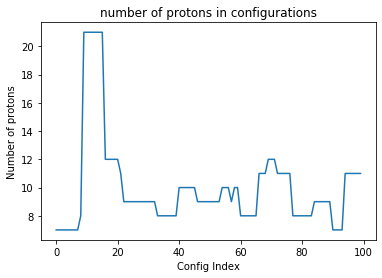

In [8]:
plt.title("number of protons in configurations")
plt.xlabel('Config Index')
plt.ylabel('Number of protons')
plt.plot(np.arange(len(protons)),protons)
plt.show()

(array([12., 21., 26., 11., 15.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         7.]),
 array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 <a list of 14 Patch objects>)

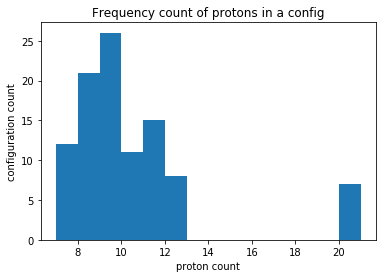

In [9]:
plt.title("Frequency count of protons in a config")
plt.xlabel("proton count")
plt.ylabel("configuration count")
plt.hist(protons, bins=np.arange(protons.min(), protons.max()+1))


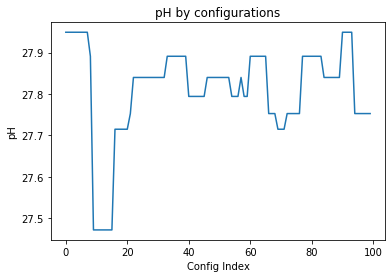

In [18]:
plt.title("pH by configurations")
plt.xlabel('Config Index')
plt.ylabel('pH')
plt.plot(np.arange(len(ph)),ph)
plt.show()